In [552]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from tensorflow.keras import optimizers
import random

import keras

import tensorflow as tf

# sm.set_framework('tf.keras')
# sm.framework()

In [553]:
seed = 24
batch_size = 2
n_classes = 5

In [554]:
BACKBONE = 'vgg19'

In [555]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

In [556]:
def preprocess_data(img, mask, num_class):

    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    mask = mask - 1
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [557]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):

    # print(train_img_path)

    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    # print(img_data_gen_args)
  
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        # target_size = (64, 64),
        target_size = (256, 256),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    # print(image_generator)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        # target_size = (64, 64),
        target_size = (256, 256),
        # color_mode='rgb',
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        # print(img.shape)
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [558]:
train_img_path = "/home/shrayank_mistry/Modules/data/my_data_v2/train_images/"
train_mask_path = "/home/shrayank_mistry/Modules/data/my_data_v2/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class = 5)

val_img_path = "/home/shrayank_mistry/Modules/data/my_data_v2/val_images/"
val_mask_path = "/home/shrayank_mistry/Modules//data/my_data_v2/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class = 5)

In [559]:
x, y = train_img_gen.__next__()
x_val, y_val = val_img_gen.__next__()

Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


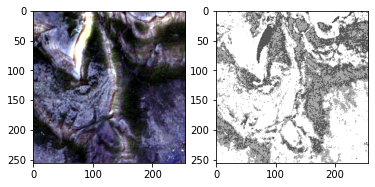

In [560]:
for i in range(0,1):
    image = x[i]

    # print(image)
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [561]:
num_train_imgs = len(os.listdir('/home/shrayank_mistry/Modules/data/my_data_v2/train_images/train/'))
num_val_images = len(os.listdir('/home/shrayank_mistry/Modules/data/my_data_v2/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

In [562]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes = 5

In [563]:
model = sm.FPN(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')

# model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
model.compile(optimizers.Adam(learning_rate = 0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [564]:
# optimizers.Adam(learning_rate = 0.001)

In [565]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=300,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/300
3/3 [==============================] - 14s 4s/step - loss: 0.9502 - iou_score: 0.1017 - val_loss: 1.4823 - val_iou_score: 0.0419
Epoch 2/300
3/3 [==============================] - 12s 4s/step - loss: 0.8843 - iou_score: 0.1522 - val_loss: 1.4967 - val_iou_score: 0.0393
Epoch 3/300
3/3 [==============================] - 12s 4s/step - loss: 0.8285 - iou_score: 0.2018 - val_loss: 1.3337 - val_iou_score: 0.0511
Epoch 4/300
3/3 [==============================] - 11s 4s/step - loss: 0.8164 - iou_score: 0.2169 - val_loss: 1.1515 - val_iou_score: 0.0903
Epoch 5/300
3/3 [==============================] - 12s 4s/step - loss: 0.7976 - iou_score: 0.2307 - val_loss: 0.9568 - val_iou_score: 0.1975
Epoch 6/300
3/3 [==============================] - 12s 4s/step - loss: 0.7918 - iou_score: 0.2500 - val_loss: 1.0118 - val_iou_score: 0.1645
Epoch 7/300
3/3 [==============================] - 12s 4s/step - loss: 0.7640 - iou_score: 0.2641 - val_loss: 1.0515 - val_iou_score: 0.1426
Epoch 8/300
3

In [566]:
model.save('landcover_300_epochs_vgg19_backbone_batch16.hdf5')

/home/shrayank_mistry/Modules/virtualenv/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


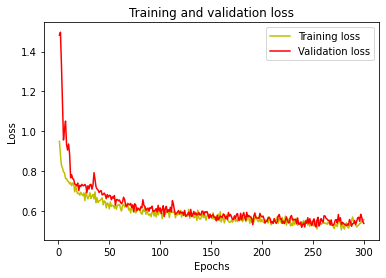

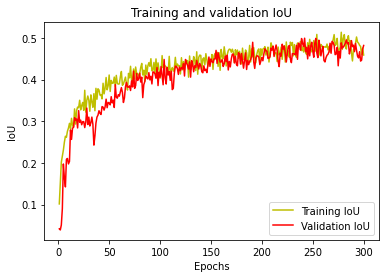

In [567]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [568]:
from keras.models import load_model

model = load_model('landcover_300_epochs_vgg19_backbone_batch16.hdf5', compile=False)

# batch_size=4 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

Mean IoU = 0.54265106


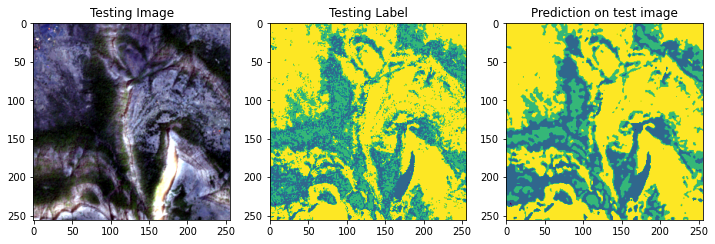

In [569]:
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()